In [50]:
import sys
sys.path.append("../")

from functools import partial
from models.losses import sigmoid_loss, softmax_loss
from models.eval_utils import retrieval_eval_metric

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from models.dataset_utils import make_dataloader, create_input_iter

batch_size = 8

files = ['../data/tfrecords_v3/observations_train_1.tfrecord','../data/tfrecords_v3/observations_train_2.tfrecord',]
ds = make_dataloader(files, batch_size=batch_size, seed=42)
batches = create_input_iter(ds)

In [5]:
import jax
from PIL import Image
import jax.numpy as np
import matplotlib.pyplot as plt

In [18]:
import optax 
from flax.training import checkpoints, common_utils, train_state
import flax

In [20]:
num_local_devices = jax.local_device_count()

## From scratch

In [3]:
from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [4]:
image, caption = next(iter(ds))

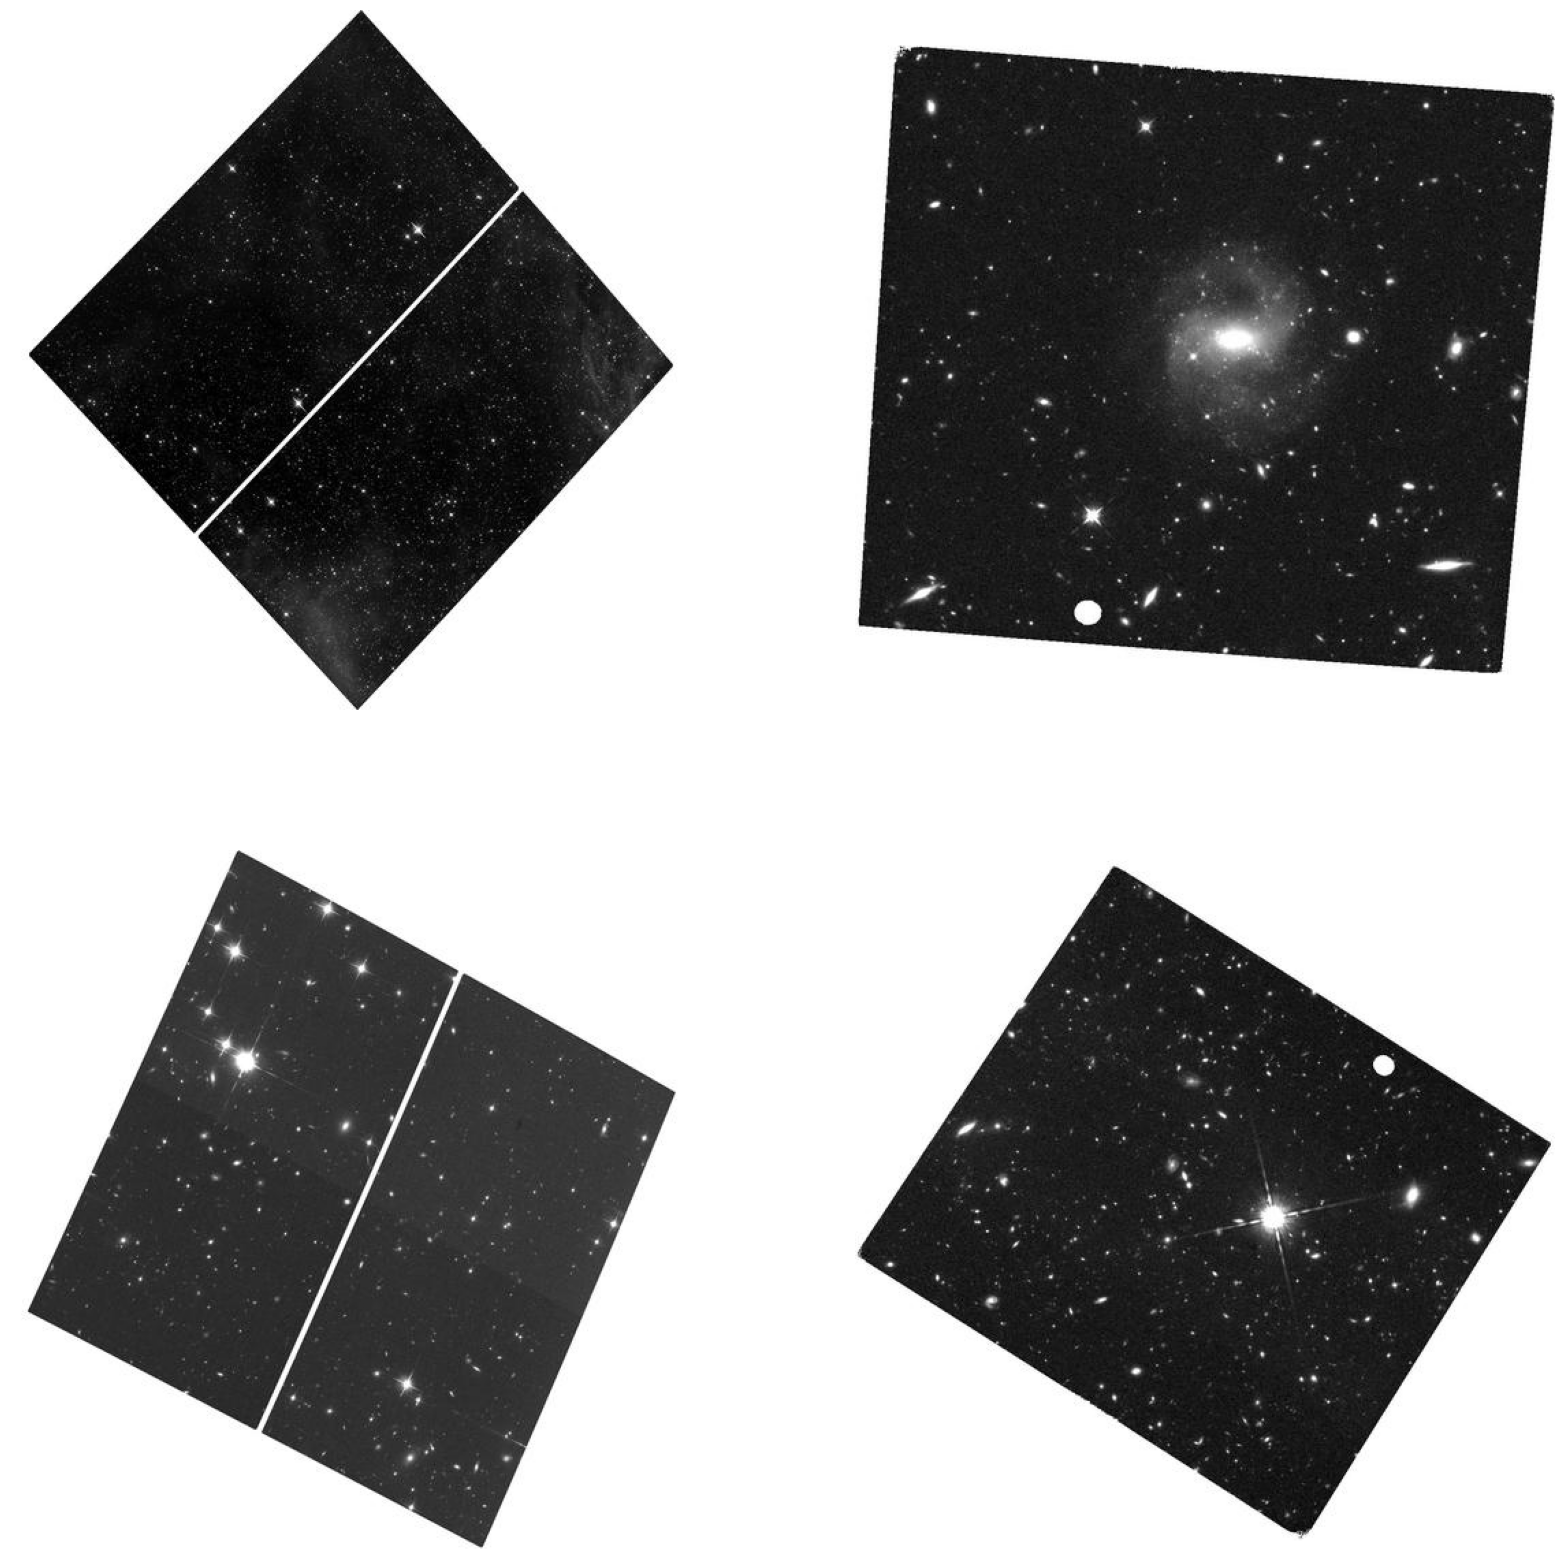

In [5]:

plt.figure(figsize=(20, 20))

grid_size = 2

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(image[i], vmin=0, vmax=1)
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [6]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

caption = caption.numpy().tolist()
caption = [c.decode('utf-8') for c in caption]

txt_inputs = tokenizer(
                    caption,
                    padding="max_length",
                    truncation=True,
                    max_length=10,
                    return_tensors="np",
                )
txt_inputs = {k: txt_inputs[k] for k in ["input_ids", "attention_mask"]}

In [7]:
text_config = {
    "dtype": "float32",
    "activations": ["gelu"],
    "use_bias": False,
    "force_scale": False,
    "attention_dropout": 0.0,
    "mlp_dropout_rate": 0.0,
    "unroll": 100,
    "gradient_checkpointing": False,
    "eos_token_id": 49407,
    "vocab_size": 50000,
    "hidden_size": 512,
    "max_length": 300,
    "num_layers": 4,
    "use_rmsnorm": True,
    "ln_type": "normformer",
    "num_heads": 8,
    "position_embedding_type": "rotary",
    "use_causal_mask": False,
    "mlp_dim": 1024
  }

vision_config ={
    "position_embedding_type": "sincos2d",
    "dtype": "float32",
    "activations": ["gelu"],
    "use_bias": False,
    "force_scale": False,
    "attention_dropout": 0.0,
    "mlp_dropout_rate": 0.0,
    "unroll": 100,
    "gradient_checkpointing": True,
    "image_size": 512,
    "hidden_size": 512,
    "patch_size": 16,
    "num_layers": 4,
    "use_rmsnorm": True,
    "ln_type": "normformer",
    "num_heads": 4,
    "use_causal_mask": False,
    "mlp_dim": 1024
}

In [8]:
transformer = CLIPTextTransformer(**text_config)

In [9]:
key = jax.random.PRNGKey(0)
output, params = transformer.init_with_output(key, txt_inputs['input_ids'], txt_inputs['attention_mask'])

2023-10-17 10:28:05.079529: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12800000]{0}, u32[12800000]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-17 10:28:05.202159: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.12285603s
Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12800000]{0}, u32[12800000]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off between

In [10]:
vit = CLIPVisionTransformer(**vision_config)

In [11]:
outputs, params = vit.init_with_output(key, image.numpy());

In [12]:
batch = {"pixel_values": image.numpy(), "input_ids": txt_inputs['input_ids'], "attention_mask": txt_inputs['attention_mask']}
batch = jax.tree_map(lambda x: np.array(x, dtype=np.float32), batch)
batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), batch)

In [13]:
clip = CLIPModel(text_config=text_config, vision_config=vision_config, projection_dim=256)

outputs, params = clip.init_with_output(key, np.array(batch["input_ids"])[0], np.array(batch["pixel_values"])[0], np.array(batch["attention_mask"])[0])

In [14]:
@partial(jax.pmap, axis_name="batch")
def eval_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = state.apply_fn(params, input_ids, images, attention_mask)
        loss = sigmoid_loss(outputs)
        retrieval_metrics = retrieval_eval_metric(outputs)
        return loss, retrieval_metrics

    loss, retrieval_metrics = loss_fn(state.params)
    
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    for key, value in retrieval_metrics.items():
        metrics[key] = jax.lax.pmean(value, "batch")

    return metrics

In [15]:
replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(apply_fn=clip.apply, params=params, tx=tx)
pstate = replicate(state)

metrics = eval_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [16]:
metrics

{'loss': Array([0.81461446], dtype=float64),
 'top_10_accuracy': Array([1.], dtype=float32),
 'top_1_accuracy': Array([0.125], dtype=float32),
 'top_5_accuracy': Array([0.625], dtype=float32)}

In [17]:
outputs, params = clip.init_with_output(key, np.array(batch["input_ids"]).reshape((batch_size, -1)), np.array(batch["pixel_values"]).reshape(batch_size, 512, 512, 3), np.array(batch["attention_mask"]).reshape(batch_size, -1))

## Pre-trained

In [3]:
from transformers import FlaxCLIPModel, AutoProcessor

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [6]:
images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [7]:
from dm_pix import random_crop, rotate
from functools import partial

# Rotate
rng_aug = jax.random.PRNGKey(42)
rotation_angles = jax.random.choice(rng_aug, np.array([0, np.pi / 2, np.pi, 3 * np.pi / 2]), shape=(images.shape[0],))  # Angles in radians
images = jax.vmap(partial(rotate, mode='constant', cval=1.))(images, rotation_angles)

# Crop
rng_aug, _ = jax.random.split(rng_aug)
images = jax.vmap(random_crop, in_axes=(None,0,None))(rng_aug, images, (model.config.vision_config.image_size, model.config.vision_config.image_size, 3))

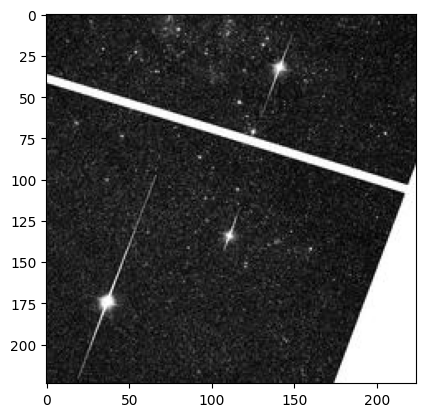

In [8]:
plt.imshow(images[1], vmin=0, vmax=1)

In [9]:
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32",)

In [10]:
inputs = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=model.config.text_config.max_length)

In [11]:
# from einops import rearrange
# plt.imshow(rearrange(inputs['pixel_values'][3], 'c h w -> h w c'))

In [12]:
import nltk


def sample_and_pad(captions, key, max_length=77):
    sampled_seqs = []

    for caption in captions:
        sentences = nltk.sent_tokenize(caption)
        
        # If the total words are already less than or equal to max_length, just append the caption
        if len(caption.split()) <= max_length:
            sampled_seqs.append(caption)
            continue

        # Get random start index for sentences
        key, subkey = jax.random.split(key)
        start_idx = jax.random.randint(subkey, minval=0, maxval=len(sentences), shape=())

        # Rotate the sentences so that the starting sentence is at the beginning
        rotated_sentences = sentences[start_idx:] + sentences[:start_idx]

        sampled_words = []
        for sent in rotated_sentences:
            if len(sampled_words) + len(sent.split()) <= max_length:
                sampled_words.extend(sent.split())
            else:
                break

        sampled_seq = " ".join(sampled_words)
        sampled_seqs.append(sampled_seq)

    return sampled_seqs

In [30]:
key = jax.random.PRNGKey(47)
sample_and_pad(captions, key)

['The afterglow of some short GRBs displays a late-time rebrightening, visible a few days after the gamma-ray burst. Recent HST observations provided tantalizing evidence that such late-time bump could be explained as the emergence of the underlying kilonova emission. This would represent the incontrovertible signature of a neutron star merger, and the first direct link between short GRBs and their progenitors.',
 'We propose to obtain high spatial resolution, long-slit spectroscopy of two globular clusters in M31, G78 and G280. These two clusters represent the best ones in which to constrain a central black hole. Most importantly, both of these clusters have long central relaxation times, and thus confusion between a central black hole and a collection of heavy stellar remnants is alleviated.',
 'The broader applications of our project include 1} the calibration of mass-temperature and mass-SZE scaling relations which will be critical for the calibration of proposed dark energy experi

In [32]:
images *= 255

inputs = processor(
    text=captions, images=images, 
    return_tensors="np", 
    padding="max_length",
    truncation=True,
    max_length=77,
)

In [33]:
outputs = model(**inputs, params=model.params)

In [34]:
text_embeds = outputs["text_embeds"]
image_embeds = outputs["image_embeds"]

logits = np.matmul(text_embeds, image_embeds.T)

k = [1, 5, 10, 20]

# Compute the global top-k indices for the maximum k value
max_k = max(k)
top_k_indices = np.argsort(logits, axis=-1)[:, -max_k:]

correct_indices = np.arange(text_embeds.shape[0])[:, None]

metrics = {}
for current_k in k:
    # Check if the correct image (diagonal) is in the current top-k for each text embedding
    correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
    accuracy = np.mean(correct_in_top_k.astype(np.float32))
    metrics[f"top_{current_k}_accuracy"] = accuracy

metrics

{'top_1_accuracy': Array(0.125, dtype=float32),
 'top_5_accuracy': Array(0.625, dtype=float32),
 'top_10_accuracy': Array(1., dtype=float32),
 'top_20_accuracy': Array(1., dtype=float32)}

In [53]:
from flax.core import FrozenDict

@partial(jax.pmap, axis_name="batch")
def train_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = model(input_ids, images, attention_mask, params=params)
        outputs['logit_scale'] = model.params['logit_scale']
        outputs['logit_bias'] = model.params.get('logit_bias', 0.)
        
        loss = softmax_loss(outputs)
        # loss = sigmoid_loss(outputs)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics


replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(
    apply_fn=model.__call__,
    params=FrozenDict(model.params) ,
    tx=tx,
)

pstate = replicate(state)

batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), inputs.data)
new_pstate, metrics = train_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [54]:
metrics

{'loss': Array([2.065662], dtype=float32)}